In [1]:
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

In [2]:
import pycocotools

In [3]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

Example of data in annotation files

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

Number of images per split

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann= json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [6]:
print(len(cis_test_ann['images']))
print(len(cis_val_ann['images']))
print(len(train_ann['images']))
print(len(trans_test_ann['images']))
print(len(trans_val_ann['images']))

15827
3484
13553
23275
1725


In [7]:
trans_val_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [8]:
trans_val_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': 'Caltech Camera Traps - ECCV18',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'year': 2018}

In [9]:
trans_val_ann['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'}]

In [10]:
trans_val_ann['annotations'][0]

{'image_id': '58df680b-23d2-11e8-a6a3-ec086b02610b',
 'category_id': 6,
 'bbox': [1123.7375892857142,
  787.8743750000001,
  284.6749107142857,
  244.2854464285715],
 'id': '19220'}

## Horizontal flip debugging

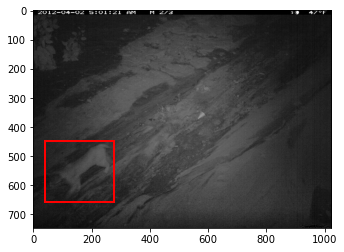

In [11]:
i = 500

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [12]:
image = Image.open(img_path).convert("RGB")
#image=conv(image)

In [13]:
image.size

(1024, 747)

In [14]:
conv = torchvision.transforms.ToTensor()

In [15]:
width, height = image.size[0], image.size[1]

In [16]:
width

1024

In [17]:
height

747

In [18]:
image_new = conv(image)

In [19]:
print(image_new.shape)

torch.Size([3, 747, 1024])


## Utils

In [21]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {
    'train': T.RandomHorizontalFlip(0.5)}

In [22]:
def get_img_with_bbox(file_path):
  
    # returns a list with the idx of images with at least one bounding box (img_wbbox) and a list with the number of bbox for each valid image (num_bbox)
    file = json.load(open(file_path))
    img_wbbox=[]
    num_bbox=[]

    for i in range(len(file['images'])):
        bboxes= [file['annotations'][j]['bbox'] for j in range(len(file['annotations'])) if file['annotations'][j]['image_id']==file['images'][i]['id'] and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform= None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img= valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx=self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv=torchvision.transforms.ToTensor()
        #if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image=conv(image)

        boxes= [self.label_file['annotations'][j]['bbox'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        label= [self.label_file['annotations'][j]['category_id'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x=image.shape[2]/self.label_file['images'][idx]['width'] 
        scale_y=image.shape[1]/self.label_file['images'][idx]['height']

        boxes=torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0]=torch.round(boxes[i][0]*scale_x)
            boxes[i][1]=torch.round(boxes[i][1]*scale_y)
            boxes[i][2]=torch.round(boxes[i][2]*scale_x)
            boxes[i][3]=torch.round(boxes[i][3]*scale_y)

            boxes[i][2]=boxes[i][0]+boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3]=boxes[i][1]+boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label=torch.as_tensor(label)
        label=torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target


Example of use

In [24]:
# get the images bounding boxes *takes about 25sec*
train_valid_img,_ = get_img_with_bbox(train_ann_path)
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)

In [25]:
training_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

# In paper : ' We use a batch size of 1'

Target (Bbox) batch shape: torch.Size([1, 4])
Target (category) batch shape: torch.Size([1])
Label: animal


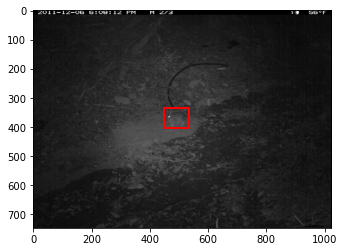

In [26]:
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Target (Bbox) batch shape: {train_labels[0]['boxes'].size()}")
print(f"Target (category) batch shape: {train_labels[0]['labels'].size()}")

img = train_features[0][0].squeeze()
label = train_labels[0]['labels']
label_categ='animal'

if label[0]==0:
    label_categ='background'

fig, ax = plt.subplots()
ax.imshow(img,cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print(f"Label: {label_categ}")

## Horizontal flip debugging p2

In [ ]:
# trans = data_transform['train']
# img2, target2 = trans(image, target)

# fig, ax = plt.subplots()
# ax.imshow(img2[0].squeeze(), cmap="gray")

# rect = patches.Rectangle((target2['boxes'][0][0], target2['boxes'][0][1]), 
#                          target2['boxes'][0][2] - target2['boxes'][0][0], 
#                          target2['boxes'][0][3] - target2['boxes'][0][1], 
#                          linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

## Pre-trained model

In [ ]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

In [27]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [29]:
# train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [30]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data = CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [31]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data = CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [32]:
# !!TO DO : replace this 'return coco_evaluator' by this 'return metric_logger' on line 
# #109 of engine.py in evaluate function and CTRL+S

In [33]:
# way around weird behav
# del evaluate
# from engine_modif import train_one_epoch, evaluate

In [ ]:
# TRAIN

all_train_logs = []
all_trans_valid_logs = []
all_cis_valid_logs = []

num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 7:41:49  lr: 0.000001  loss: 1.0190 (1.0190)  loss_classifier: 0.8890 (0.8890)  loss_box_reg: 0.1273 (0.1273)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 2.2902  data: 0.0380  max mem: 524
Epoch: [0]  [  100/12099]  eta: 0:28:20  lr: 0.000031  loss: 0.3685 (0.7021)  loss_classifier: 0.2101 (0.5354)  loss_box_reg: 0.1411 (0.1336)  loss_objectness: 0.0093 (0.0269)  loss_rpn_box_reg: 0.0029 (0.0062)  time: 0.1166  data: 0.0337  max mem: 524
Epoch: [0]  [  200/12099]  eta: 0:25:18  lr: 0.000061  loss: 0.2666 (0.4957)  loss_classifier: 0.0966 (0.3309)  loss_box_reg: 0.0924 (0.1269)  loss_objectness: 0.0129 (0.0308)  loss_rpn_box_reg: 0.0039 (0.0071)  time: 0.1121  data: 0.0294  max mem: 524
Epoch: [0]  [  300/12099]  eta: 0:24:11  lr: 0.000091  loss: 0.2557 (0.4133)  loss_classifier: 0.0930 (0.2524)  loss_box_reg: 0.0918 (0.1206)  loss_objectness: 0.0257 (0.0325)  loss_rpn_box_reg: 0.0048 (0.0077)  time: 0.1169  data: 0.0327  m

In [ ]:
# save the model, the optimizer and any other info using state_dicts

torch.save(
    {
        "model": model_1.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": e,
        "batch_size": batch_size,
    },
    "./state_dicts_1.pt",
)

state_dicts = torch.load("./state_dicts_1.pt")
resumed_dict_1 = LinearModel(1, 1)
resumed_dict_1.load_state_dict(
    state_dicts["model"]
)  # requires the base class of the model

assert (resumed_dict_1(x) == model_1(x)).all()

# exactly the same goes for the optimizer

In [ ]:
# Load the model **NEED TO EVAL RIGHT AFTER**
model.load_state_dict(torch.load('saved_models/model_weights.pth'))
model.eval()

In [ ]:
all_train_logs[19].meters

In [ ]:
all_train_logs[19].meters['loss'].value

In [ ]:
all_train_logs[19].meters['loss'].global_avg

In [ ]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

In [ ]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

### Put train logs in json files
There are multiple values coming from the MetricLogger so we can decide which we want to keep.

In [ ]:
# Converts the train logs from MetricLogger to string
def train_logs_to_lst(logs):
    lst = []
    print(type(logs))
    for i in range(len(logs)):
        n = len(logs[i].meters.items())
        d = {}
        for key in logs[i].meters.keys():
            d[key] = logs[i].meters[key].value
        lst.append(d)
    return lst

In [ ]:
# Converting the logs to string then to a json file
all_train_logs_str = train_logs_to_lst(all_train_logs)

In [ ]:
# Puts the logs in string format into a json file
with open('jsons/train_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_train_logs_str, f, ensure_ascii=False, indent=4)

### Put valid logs in json files

In [ ]:
# https://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    for i in range(len(logs)):
        logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
    return logs_better

In [ ]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_lst(logs):
    logs = merge_dict(logs)
    lst = []
    print(type(logs))
    for i in range(len(logs)):
        n = len(logs[i].items())
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].numpy().tolist()
        lst.append(d)
    return lst

In [ ]:
# Converting the cis logs to string then to a json file
all_cis_valid_logs_str = valid_logs_to_lst(all_cis_valid_logs)

In [ ]:
# Puts the logs in string format into a json file
with open('jsons/cis_valid_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_cis_valid_logs_str, f, ensure_ascii=False, indent=4)

In [ ]:
# Converting the trans logs to string then to a json file
all_trans_valid_logs_str = valid_logs_to_lst(all_trans_valid_logs)

In [ ]:
# Puts the trans logs in string format into a json file
with open('jsons/trans_valid_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_trans_valid_logs_str, f, ensure_ascii=False, indent=4)

## Résultats de l'entrainement

In [ ]:
all_train_logs[0].meters

In [ ]:
# Make better dict temporarily
all_cis_valid_logs_better = merge_dict(all_cis_valid_logs)
all_trans_valid_logs_better = merge_dict(all_trans_valid_logs)

In [ ]:
# Visualisations

train_loss = []
train_loss_box_reg = []
train_loss_global_avg = []
cis_valid_loss = []
cis_valid_loss_box_reg = []
trans_valid_loss = []
trans_valid_loss_box_reg = []
fig, ax = plt.subplots(1,2, figsize=(20,6))

for i in range(num_epochs):
    train_loss.append(all_train_logs[i].meters['loss'].value)
    train_loss_box_reg.append(all_train_logs[i].meters['loss_box_reg'].value)

    trans_valid_loss.append(all_trans_valid_logs_better[i]['loss_classifier'].numpy())
    trans_valid_loss_box_reg.append(all_trans_valid_logs_better[i]['loss_box_reg'].numpy())

    cis_valid_loss.append(all_cis_valid_logs_better[i]['loss_classifier'].numpy())
    cis_valid_loss_box_reg.append(all_cis_valid_logs_better[i]['loss_box_reg'].numpy())

ax[0].plot(np.arange(num_epochs),train_loss, label='train')
ax[0].plot(np.arange(num_epochs),trans_valid_loss, label='trans valid')
ax[0].plot(np.arange(num_epochs),cis_valid_loss, label='cis valid')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(np.arange(num_epochs),train_loss_box_reg,label='train')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')

In [ ]:
# Visualisations
train_loss_avg = []
cis_valid_loss_avg = []
trans_valid_loss_avg = []


To obtain predicitons

In [ ]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
    pred=model(image)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[0][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

ax[1].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in range(len(pred[0]['boxes'])):
    rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

#NMS
iou_threshold=0.005 # param to tune
boxes_to_keep=torchvision.ops.nms(pred[0]['boxes'],pred[0]['scores'],iou_threshold=iou_threshold).cpu()
ax[2].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
  rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
  ax[2].add_patch(rect)

ax[2].set_title('After NMS')


In [ ]:
# ' For evaluation, we consider a detected box to be correct if its IoU≥ 0.5 with a ground truth box.'

In [ ]:
# doesnt seem to change something to do this before the MAP 
pred[0]['boxes']=pred[0]['boxes'][boxes_to_keep]
pred[0]['labels']=pred[0]['labels'][boxes_to_keep]
pred[0]['scores']=pred[0]['scores'][boxes_to_keep]

Metrics

In [ ]:
metric = MeanAveragePrecision( max_detection_thresholds=[2])
metric.update(pred, list(train_labels))
from pprint import pprint
pprint(metric.compute())

In [ ]:
model.roi_heads # original roi heads

In [ ]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (animal) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# We would prob need to change the size in 
# Resize(min_size=(800,), max_size=1333, mode='bilinear')


## CEt Ligne est ecrit par Abdiel
## Celle-ci est écrite par Kevin.

# As well as the output size in the fc of the FastRCNN Predictor
#(cls_score): Linear(in_features=1024, out_features=91, bias=True)
#(bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
